In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.transforms as transforms
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

## Constants

In [2]:
# Taken from https://deepgraphlearning.github.io/project/wikidata5m
WIKIDATA5M_TRANSDUCTIVE_NUM_ENTITIES = 4_594_485

# Set Seaborn theme
SEABORN_THEME = 'darkgrid'
sns.set_theme(style=SEABORN_THEME)

## Load Wikidata5M

In [3]:
# Load Wikidata5M to check how often selected predicates
# occur in the training set
wikidata5m_train = pd.read_csv('dataset/wikidata5m/wikidata5m_transductive_train.txt', sep='\t', names=['S', 'P', 'O'])

## Acquiring relevant metrics from dim32 embeddings

In [4]:
dim32_predicate_metrics = pd.read_csv('metrics/predicate_metrics.csv')

# Only consider realistic values, evaluated on both ends
dim32_predicate_metrics = dim32_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [5]:
# Filter for selected metrics to compare on
selected_metrics = ['arithmetic_mean_rank', 'hits_at_5', 'hits_at_10']

dim32_predicate_metrics = dim32_predicate_metrics[dim32_predicate_metrics['Metric'].isin(selected_metrics)]
dim32_predicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
140,both,realistic,arithmetic_mean_rank,828467.750,1,P1001,complex
194,both,realistic,hits_at_5,0.000,1,P1001,complex
203,both,realistic,hits_at_10,0.000,1,P1001,complex
365,both,realistic,arithmetic_mean_rank,1950983.625,3,P101,complex
419,both,realistic,hits_at_5,0.000,3,P101,complex
...,...,...,...,...,...,...,...
188744,both,realistic,hits_at_5,0.500,813,P945,transe
188753,both,realistic,hits_at_10,0.500,813,P945,transe
188915,both,realistic,arithmetic_mean_rank,16547.375,815,P97,transe
188969,both,realistic,hits_at_5,0.250,815,P97,transe


## Acquiring relevant metrics from dim512 embeddings

In [6]:
dim512_complex_metrics = pd.read_csv('embeddings/dim_512/complex/predicate_metrics.csv')
dim512_distmult_metrics = pd.read_csv('embeddings/dim_512/distmult/predicate_metrics.csv')
dim512_simple_metrics = pd.read_csv('embeddings/dim_512/simple/predicate_metrics.csv')
dim512_transe_metrics = pd.read_csv('embeddings/dim_512/transe/predicate_metrics.csv')

dim512_predicate_metrics = pd.concat([dim512_complex_metrics, dim512_distmult_metrics, dim512_simple_metrics, dim512_transe_metrics])
dim512_predicate_metrics = dim512_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [7]:
# Filter for selected metrics
dim512_predicate_metrics = dim512_predicate_metrics[dim512_predicate_metrics['Metric'].isin(selected_metrics)]
dim512_predicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
41,both,realistic,arithmetic_mean_rank,935941.750000,0,P31,complex
194,both,realistic,hits_at_5,0.162088,0,P31,complex
203,both,realistic,hits_at_10,0.211538,0,P31,complex
266,both,realistic,arithmetic_mean_rank,598365.812500,1,P1412,complex
419,both,realistic,hits_at_5,0.022059,1,P1412,complex
...,...,...,...,...,...,...,...
46994,both,realistic,hits_at_5,0.500000,469,P511,transe
47003,both,realistic,hits_at_10,0.500000,469,P511,transe
47174,both,realistic,arithmetic_mean_rank,76.000000,492,P832,transe
47219,both,realistic,hits_at_5,0.000000,492,P832,transe


## Acquiring predicate counts for example predicates

In [8]:
dim32_example_predicates_counts = pd.read_csv('metrics/example_predicate_counts.csv')

## Utility Functions

In [9]:
def get_wikidata_property_labels(property_ids: list) -> dict:
    wikidata_api = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(property_ids),
        'languages': 'en',
        'props': 'labels',
        'format': 'json'
    }

    response = requests.get(wikidata_api, params).json()

    property_labels = {}
    for pid in property_ids:
        property_labels[pid] = response['entities'][pid]['labels']['en']['value']

    return property_labels


def get_metric_label(metric_name):
    if metric_name == 'arithmetic_mean_rank':
        return 'Arithmetic Mean Rank'
    elif metric_name == 'hits_at_5':
        return 'Hits at 5'
    elif metric_name == 'hits_at_10':
        return 'Hits at 10'

    return metric_name


def set_plot_legend_texts(plot_ax, legend_title, legend_labels):
    legend = plot_ax.get_legend()
    legend.set_title(legend_title)
    
    for lt, label in zip(legend.texts, legend_labels):
        lt.set_text(label)

## Predicate Distribution in Wikidata5M

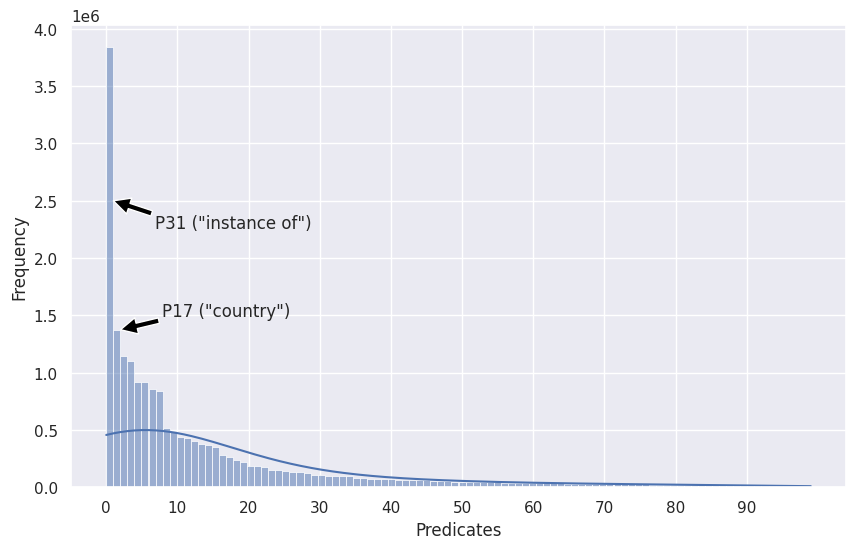

In [10]:
def plot_predicate_frequencies(triples_df):
    p_frequencies = triples_df.value_counts(['P'], sort=True).reset_index()
    p_frequencies = p_frequencies.reset_index()

    num_bins = 100
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=p_frequencies.iloc[:num_bins], x='index', weights='count', bins=num_bins, kde=True)
    
    xtick_distance = 10
    xticks = np.arange(0, num_bins, xtick_distance)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    
    #ax.set_title('Most frequent Predicates in Wikidata5M')
    ax.set_xlabel('Predicates')
    ax.set_ylabel('Frequency')
    
    most_freq_pred = p_frequencies.iloc[0]['P']
    annotate_text = f'{most_freq_pred} ("{get_wikidata_property_labels([most_freq_pred])[most_freq_pred]}")'
    ax.annotate(annotate_text, xy=(1, 2.5e6), xytext=(30, -20), textcoords='offset points', arrowprops=dict(facecolor='black'))

    second_most_freq = p_frequencies.iloc[1]
    second_most_freq_pred = second_most_freq['P']
    annotate_text = f'{second_most_freq_pred} ("{get_wikidata_property_labels([second_most_freq_pred])[second_most_freq_pred]}")'
    ax.annotate(annotate_text, xy=(2, second_most_freq['count']), xytext=(30, 10), textcoords='offset points', arrowprops=dict(facecolor='black'))
    
    plt.savefig('./plots/wikidata5m_most_frequent_predicates.pdf', bbox_inches='tight')
    plt.show()
    

plot_predicate_frequencies(wikidata5m_train)

## Metric Histograms for selected metrics

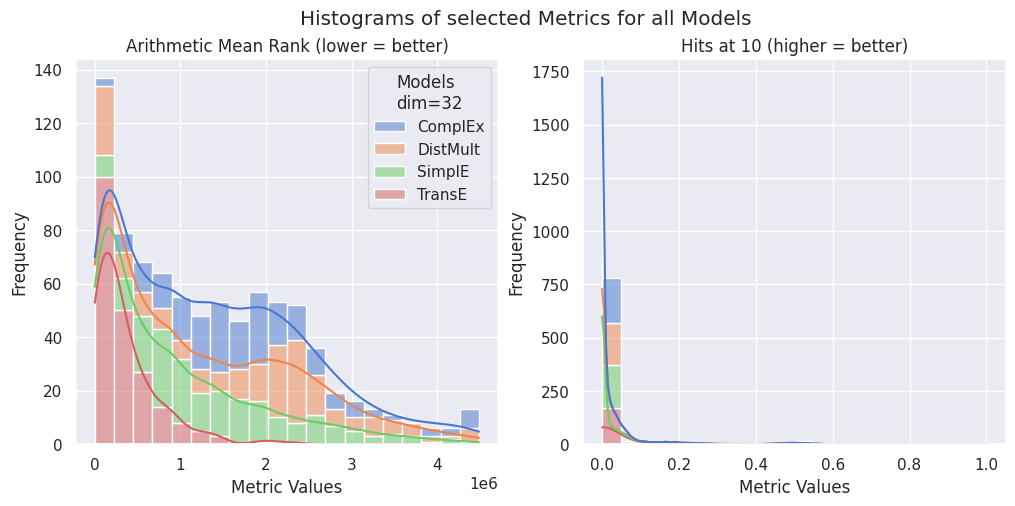

In [11]:
def plot_metric_histogram(predicate_metrics, metric_name, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)
    
    mean_ranks_df = predicate_metrics[predicate_metrics['Metric'] == 'arithmetic_mean_rank']
    hits_at_k_df = predicate_metrics[predicate_metrics['Metric'] == 'hits_at_10']

    models_list = mean_ranks_df['model'].sort_values().unique()
    metric_label = get_metric_label(metric_name)
    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
    model_colors = sns.color_palette(palette='muted')[:4]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    fig.suptitle('Histograms of selected Metrics for all Models')

    # Create a joint plot
    sns.histplot(data=mean_ranks_df, ax=axs[0], x='Value', hue='model', bins=20, kde=True, multiple='stack', palette=model_colors)
    axs[0].set(title='Arithmetic Mean Rank (lower = better)', xlabel='Metric Values', ylabel='Frequency')
    
    sns.histplot(data=hits_at_k_df, ax=axs[1], x='Value', hue='model', bins=20, kde=True, multiple='stack', palette=model_colors, legend=False)
    axs[1].set(title='Hits at 10 (higher = better)', xlabel='Metric Values', ylabel='Frequency')

    # Change legend labels and title to capitalized names
    set_plot_legend_texts(axs[0], f'Models\ndim={embedding_dim}', model_labels)

    # Add titles and labels
    #plt.title(f'Histogram of {metric_label}')
    #plt.xlabel('Metric Values')
    #plt.ylabel('Frequency')

    # Show the plot
    plt.savefig(f'./plots/dim{embedding_dim}_metric_histograms.pdf', bbox_inches='tight')
    plt.show()


plot_metric_histogram(dim32_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=32)
# plot_metric_histogram(dim32_predicate_metrics, 'hits_at_10', embedding_dim=32)

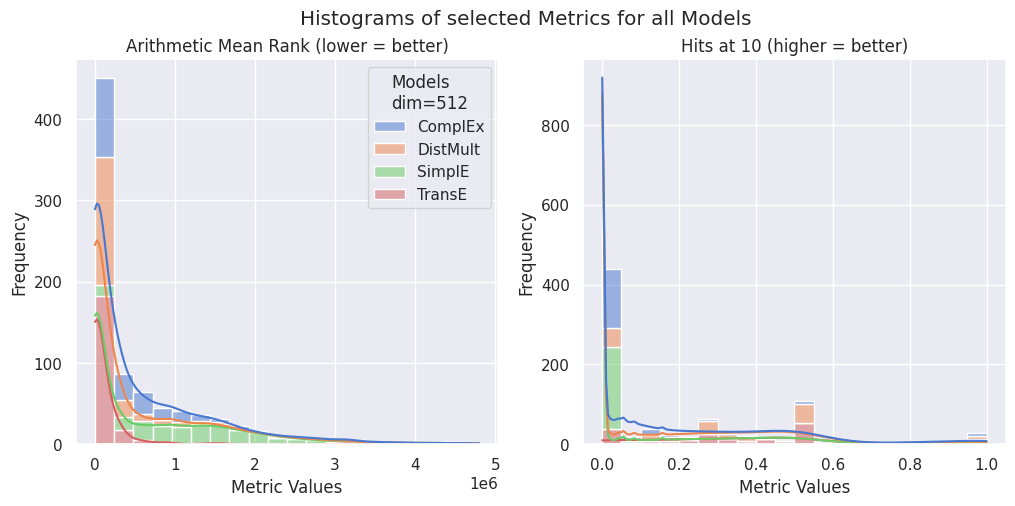

In [12]:
plot_metric_histogram(dim512_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=512)
#plot_metric_histogram(dim512_predicate_metrics, 'hits_at_10', embedding_dim=512)

## Metric Distributions over all predicates

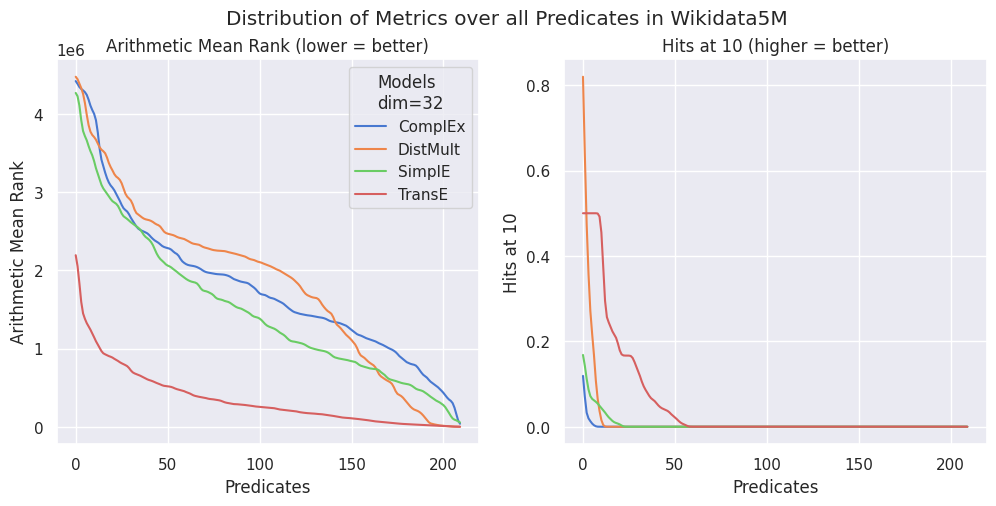

In [13]:
def compute_savgol_filter(metrics_df, window_size, polyorder):
    return metrics_df.assign(value_smooth=savgol_filter(metrics_df['Value'], window_size, polyorder))


def compute_gaussian_filter(metrics_df, sigma=1):
    return metrics_df.assign(value_smooth=gaussian_filter1d(metrics_df['Value'], sigma=sigma))


def plot_predicate_metric_distributions(predicate_metrics, metric_name, embedding_dim=32, smoothen=True):
    sns.set_theme(style=SEABORN_THEME)

    mean_ranks_df = predicate_metrics[predicate_metrics['Metric'] == 'arithmetic_mean_rank']
    hits_at_k_df = predicate_metrics[predicate_metrics['Metric'] == 'hits_at_10']

    metric_label = get_metric_label(metric_name)
    models_list = mean_ranks_df['model'].sort_values().unique()
    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
    model_colors = sns.color_palette(palette='muted')[:4]

    smoothen_window_size = 10
    smoothen_polyorder = 2

    aggregated_metrics_df = []
    for metrics_df in [mean_ranks_df, hits_at_k_df]:
        indexed_metrics = []
        for model in models_list:
            model_metrics = metrics_df[metrics_df['model'] == model]
            model_metrics = model_metrics.sort_values(by='Value', ascending=False, ignore_index=True).reset_index()
    
            if smoothen:
                model_metrics = compute_gaussian_filter(model_metrics, sigma=1)
    
            indexed_metrics.append(model_metrics)
    
        aggregated_metrics_df.append(pd.concat(indexed_metrics))

    value_column = 'Value'
    if smoothen:
        value_column = 'value_smooth'

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    fig.suptitle('Distribution of Metrics over all Predicates in Wikidata5M')

    sns.lineplot(x='index', y=value_column, hue='model', data=aggregated_metrics_df[0], ax=axs[0], estimator='mean',
                 palette=model_colors)
    axs[0].set(title='Arithmetic Mean Rank (lower = better)', xlabel='Predicates', ylabel='Arithmetic Mean Rank')
    
    sns.lineplot(x='index', y=value_column, hue='model', data=aggregated_metrics_df[1], ax=axs[1], estimator='mean',
                 palette=model_colors, legend=False)
    axs[1].set(title='Hits at 10 (higher = better)', xlabel='Predicates', ylabel='Hits at 10')

    # Change legend labels and title to capitalized names
    set_plot_legend_texts(axs[0], f'Models\ndim={embedding_dim}', model_labels)

    #plt.title(f'Distribution of {metric_label} over all predicates\n(sorted from highest to lowest)')
    #plt.xlabel('Predicates')
    #plt.ylabel(metric_label)

    plt.savefig(f'./plots/dim{embedding_dim}_metric_distributions.pdf', bbox_inches='tight')
    plt.show()


plot_predicate_metric_distributions(dim32_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=32)
# plot_predicate_metric_distributions(dim32_predicate_metrics, 'hits_at_10', embedding_dim=32)

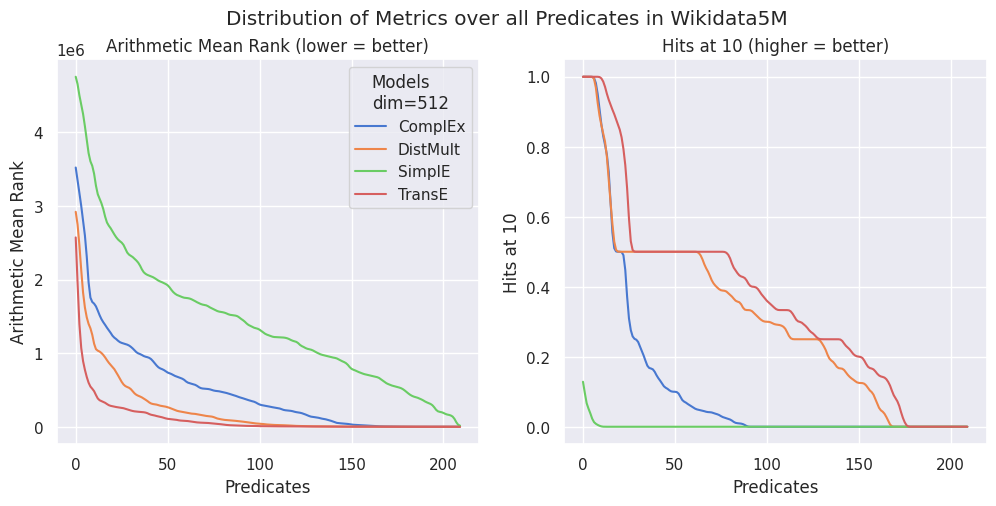

In [14]:
plot_predicate_metric_distributions(dim512_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=512)
# plot_predicate_metric_distributions(dim512_predicate_metrics, 'hits_at_10', embedding_dim=512)

## Selecting predicates with varying metrics per model 

In [15]:
def find_largest_metric_variances(predicate_metrics):
    predicates = predicate_metrics['relation_label'].unique()
    metric_names = predicate_metrics['Metric'].unique()
    model_names = predicate_metrics['model'].unique()

    metric_values = np.empty((len(predicates), len(metric_names), len(model_names)))

    for y, metric_name in enumerate(metric_names):
        for z, model_name in enumerate(model_names):
            metrics = predicate_metrics.query('Metric == @metric_name and model == @model_name')

            metric_values[:, y, z] = metrics['Value'].values

    metric_variances = np.var(metric_values, axis=2).mean(axis=1)

    variances_df = pd.DataFrame({
        'relation_label': predicates,
        'variance': metric_variances
    })

    return variances_df.sort_values(by='variance', ascending=False, ignore_index=True)


variances_df = find_largest_metric_variances(dim32_predicate_metrics)

# Limit to the highest 5 variances
variances_df = variances_df.head(5)

In [16]:
def filter_metrics(metrics_df, metric_name, filter_func):
    return metrics_df[metrics_df.apply(lambda x: x.Metric == metric_name and filter_func(x.Value), axis=1)]


dim32_hits10_nonzero = filter_metrics(dim32_predicate_metrics, 'hits_at_10', lambda value: value > 0)
dim32_hits10_nonzero.sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
81428,both,realistic,hits_at_10,1.000000,615,P460,distmult
174803,both,realistic,hits_at_10,0.500000,590,P4312,transe
84128,both,realistic,hits_at_10,0.500000,641,P516,distmult
152303,both,realistic,hits_at_10,0.500000,133,P1435,transe
188753,both,realistic,hits_at_10,0.500000,813,P945,transe
...,...,...,...,...,...,...,...
39578,both,realistic,hits_at_10,0.005495,695,P641,complex
182678,both,realistic,hits_at_10,0.005000,714,P69,transe
179303,both,realistic,hits_at_10,0.004926,656,P54,transe
26528,both,realistic,hits_at_10,0.003304,461,P31,complex


In [17]:
filter_metrics(dim32_predicate_metrics, 'hits_at_5', lambda value: value > 0).sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
81419,both,realistic,hits_at_5,1.000000,615,P460,distmult
188744,both,realistic,hits_at_5,0.500000,813,P945,transe
186944,both,realistic,hits_at_5,0.500000,779,P859,transe
174794,both,realistic,hits_at_5,0.500000,590,P4312,transe
152294,both,realistic,hits_at_5,0.500000,133,P1435,transe
...,...,...,...,...,...,...,...
136769,both,realistic,hits_at_5,0.004762,726,P735,simple
184019,both,realistic,hits_at_5,0.002381,726,P735,transe
148019,both,realistic,hits_at_5,0.002212,83,P131,transe
100769,both,realistic,hits_at_5,0.002212,83,P131,simple


In [18]:
def select_duplicate_values(df, column):
    groups = df.groupby(by=column).size().sort_values(ascending=False)
    return pd.concat([df[df[column] == value] for value in groups[groups > 1].index.values])


predicate_duplicate_metrics = select_duplicate_values(dim32_hits10_nonzero, 'relation_label')
predicate_duplicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
26528,both,realistic,hits_at_10,0.003304,461,P31,complex
121028,both,realistic,hits_at_10,0.044604,461,P31,simple
168278,both,realistic,hits_at_10,0.042401,461,P31,transe
2228,both,realistic,hits_at_10,0.020677,27,P106,complex
96728,both,realistic,hits_at_10,0.056391,27,P106,simple
143978,both,realistic,hits_at_10,0.054511,27,P106,transe
32378,both,realistic,hits_at_10,0.037037,574,P413,complex
126878,both,realistic,hits_at_10,0.138889,574,P413,simple
174128,both,realistic,hits_at_10,0.212963,574,P413,transe
32828,both,realistic,hits_at_10,0.021053,584,P421,complex


In [19]:
def find_non_preferred_predicates_transe(df):
    # Filter for hits_at_10 and value > 0
    filtered_df = df[(df['Metric'] == 'hits_at_10') & (df['Value'] > 0)]
    hits_predicates = filtered_df['relation_label'].unique()
    
    full_metrics_df = df.query('Metric == "hits_at_10" and relation_label in @hits_predicates')
    
    non_preferred_predicates = []
    for pred, metrics_df in full_metrics_df.groupby('relation_label'):
        complex_value = metrics_df[metrics_df['model'] == 'complex']['Value'].values
        distmult_value = metrics_df[metrics_df['model'] == 'distmult']['Value'].values
        simple_value = metrics_df[metrics_df['model'] == 'simple']['Value'].values
        transe_value = metrics_df[metrics_df['model'] == 'transe']['Value'].values
        
        if any([complex_value.size > 1, distmult_value.size > 1, simple_value.size > 1, transe_value.size > 1]):
            print('More than one value selected')
        
        if any([complex_value > transe_value, distmult_value > transe_value, simple_value > transe_value]):
            non_preferred_predicates.append(pred)
            
    return non_preferred_predicates

    
def find_non_preferred_predicates_over_transe(df):
    # Create a pivot table for all data
    pivot_df = df.pivot_table(index='relation_label', columns='model', values='Value', aggfunc='mean')

    # Filter out rows where all values are NaN or zero
    filtered_pivot_df = pivot_df.dropna(how='all', axis=0).fillna(0)

    # Find predicates where at least one model has a higher value than transe
    non_preferred_predicates = filtered_pivot_df[filtered_pivot_df.apply(lambda x: any(x[x.index != 'transe'] > x['transe']), axis=1)].index.tolist()

    return non_preferred_predicates

non_preferred_predicates_transe = find_non_preferred_predicates_transe(dim32_predicate_metrics)
get_wikidata_property_labels(non_preferred_predicates_transe)

{'P102': 'member of political party',
 'P1029': 'crew member(s)',
 'P106': 'occupation',
 'P108': 'employer',
 'P118': 'league',
 'P1344': 'participant in',
 'P136': 'genre',
 'P166': 'award received',
 'P19': 'place of birth',
 'P26': 'spouse',
 'P27': 'country of citizenship',
 'P31': 'instance of',
 'P3373': 'sibling',
 'P437': 'distribution format',
 'P460': 'said to be the same as',
 'P516': 'powered by',
 'P69': 'educated at'}

Selected predicates where TransE is not best: ['P47', 'P1029', 'P106', 'P1344', 'P421', 'P27', 'P641', 'P3373', 'P69', 'P17', 'P463']

P47 ("shares border with"): transe, many > 0
P1029 ("crew member(s)"): not transe, many objects
P106 ("occupation"): not transe, many > 0
P1344 ("participant in"): not transe, many > 0
P421 ("located in time zone"): transe, many > 0
P27 ("country of citizenship"): not transe, not many objects
P641 ("sport"): transe
P3373 ("sibling"): not transe, interesting properties
P69 ("educated at"): not transe, many > 0
P463 ("member of"): 

In [20]:
get_wikidata_property_labels(predicate_duplicate_metrics['relation_label'].unique())

{'P31': 'instance of',
 'P106': 'occupation',
 'P413': 'position played on team / speciality',
 'P421': 'located in time zone',
 'P47': 'shares border with',
 'P641': 'sport',
 'P1344': 'participant in',
 'P364': 'original language of film or TV show',
 'P27': 'country of citizenship',
 'P404': 'game mode',
 'P462': 'color',
 'P17': 'country',
 'P463': 'member of',
 'P1412': 'languages spoken, written or signed',
 'P495': 'country of origin',
 'P136': 'genre',
 'P97': 'noble title',
 'P131': 'located in the administrative territorial entity',
 'P69': 'educated at',
 'P703': 'found in taxon',
 'P1196': 'manner of death',
 'P105': 'taxon rank',
 'P735': 'given name'}

In [21]:
dim32_predicate_metrics.query('Metric == "hits_at_10" and relation_label == "P47"')

,Side,Type,Metric,Value,relation_id,relation_label,model
35078,both,realistic,hits_at_10,0.000000,623,P47,complex
82328,both,realistic,hits_at_10,0.008929,623,P47,distmult
129578,both,realistic,hits_at_10,0.008929,623,P47,simple
176828,both,realistic,hits_at_10,0.026786,623,P47,transe


In [22]:
dim512_hits10_nonzero = filter_metrics(dim512_predicate_metrics, 'hits_at_10', lambda value: value > 0)
dim512_hits10_nonzero.sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
12353,both,realistic,hits_at_10,1.000000,60,P26,distmult
46103,both,realistic,hits_at_10,1.000000,431,P1542,distmult
35303,both,realistic,hits_at_10,1.000000,208,P1327,transe
12353,both,realistic,hits_at_10,1.000000,60,P26,complex
33053,both,realistic,hits_at_10,1.000000,187,P1027,transe
...,...,...,...,...,...,...,...
3578,both,realistic,hits_at_10,0.009470,16,P17,simple
2453,both,realistic,hits_at_10,0.007519,11,P106,complex
1553,both,realistic,hits_at_10,0.006608,6,P19,complex
2453,both,realistic,hits_at_10,0.003759,11,P106,simple


In [23]:
select_duplicate_values(dim512_hits10_nonzero, 'relation_label')

,Side,Type,Metric,Value,relation_id,relation_label,model
878,both,realistic,hits_at_10,0.046823,3,P27,complex
878,both,realistic,hits_at_10,0.322742,3,P27,distmult
878,both,realistic,hits_at_10,0.003344,3,P27,simple
878,both,realistic,hits_at_10,0.426421,3,P27,transe
2453,both,realistic,hits_at_10,0.007519,11,P106,complex
...,...,...,...,...,...,...,...
27878,both,realistic,hits_at_10,0.500000,149,P206,distmult
34628,both,realistic,hits_at_10,0.250000,205,P186,distmult
34628,both,realistic,hits_at_10,0.250000,205,P186,transe
39128,both,realistic,hits_at_10,0.500000,248,P2962,distmult


## Metric Comparison on selected predicates

In [24]:
example_predicates = ['P106', 'P1029', 'P641', 'P69', 'P17', 'P421', 'P47', 'P3373']
example_wd_labels = get_wikidata_property_labels(example_predicates)
example_wd_labels

{'P106': 'occupation',
 'P1029': 'crew member(s)',
 'P641': 'sport',
 'P69': 'educated at',
 'P17': 'country',
 'P421': 'located in time zone',
 'P47': 'shares border with',
 'P3373': 'sibling'}

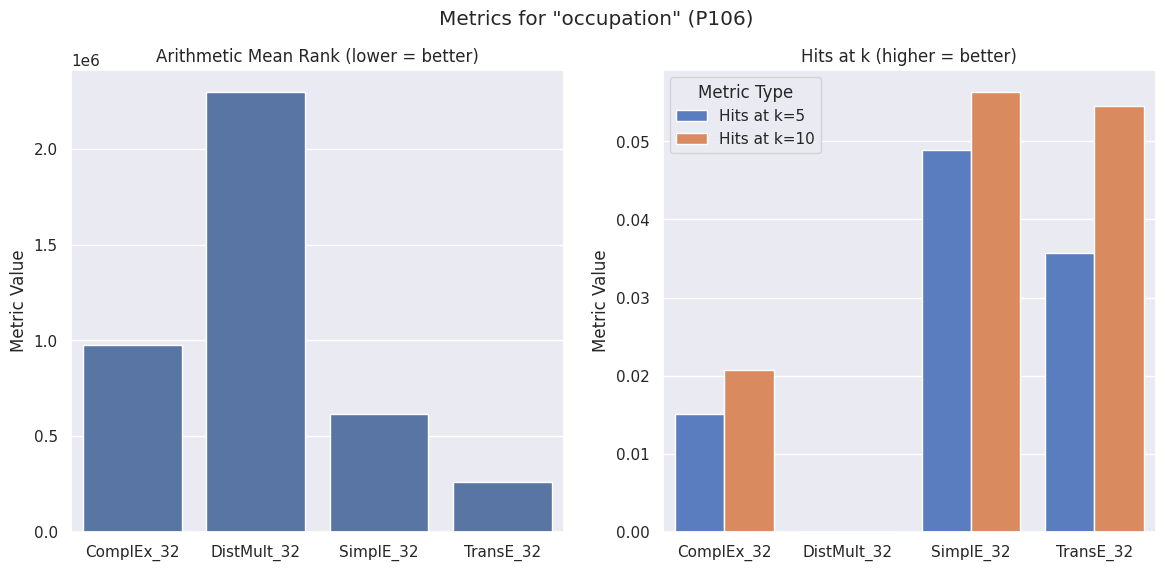

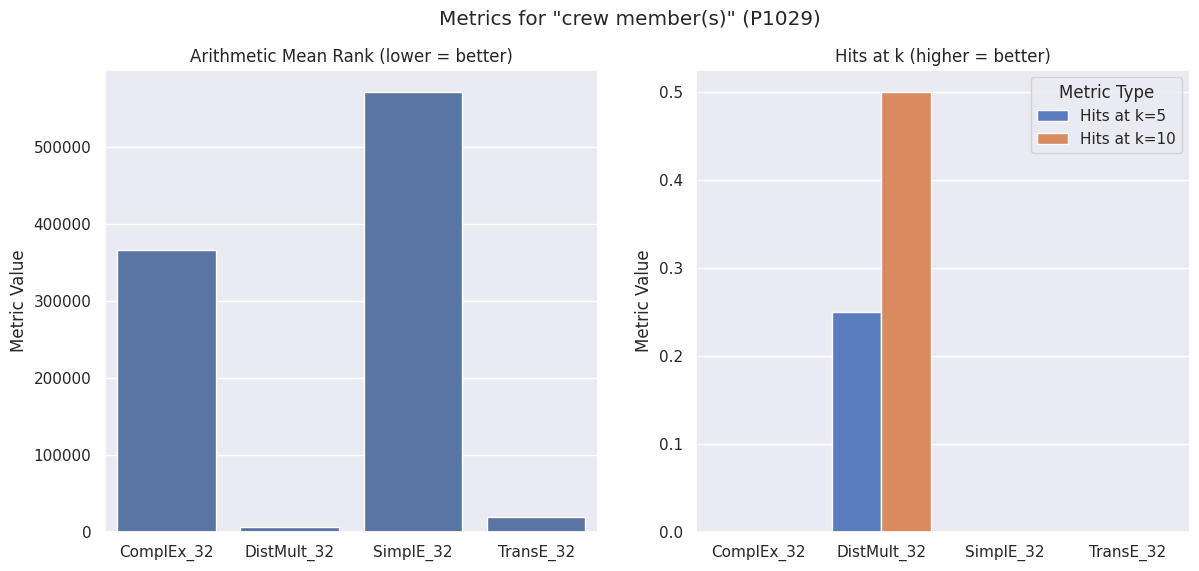

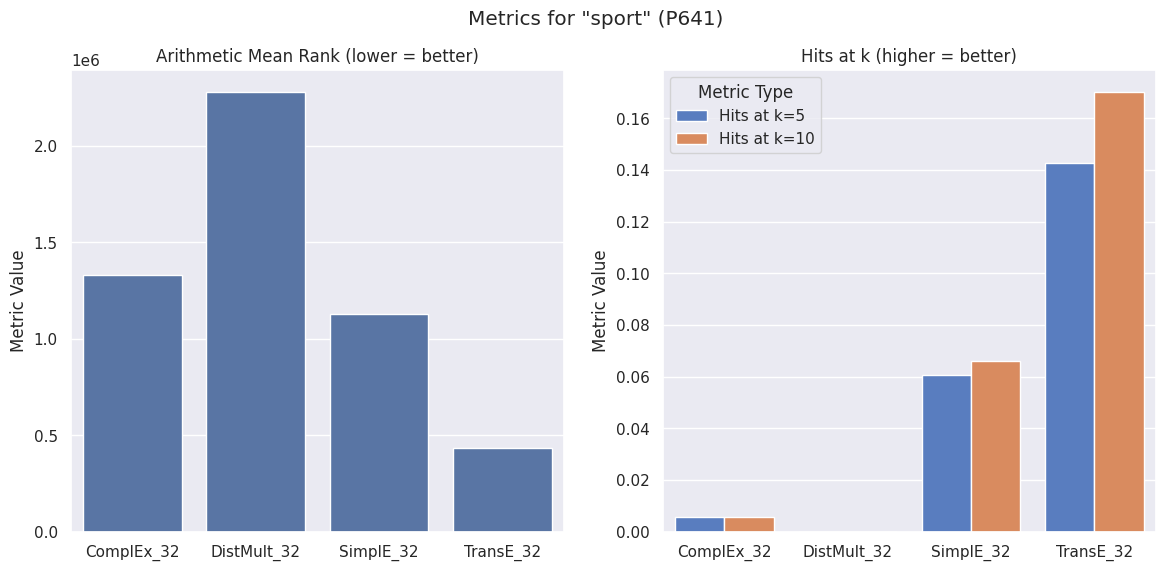

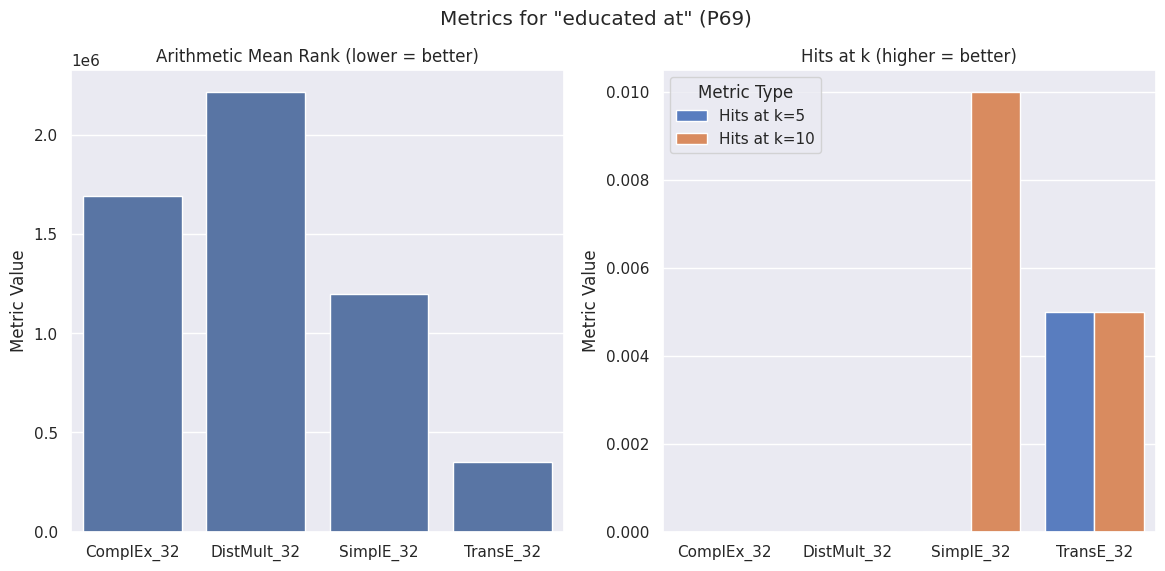

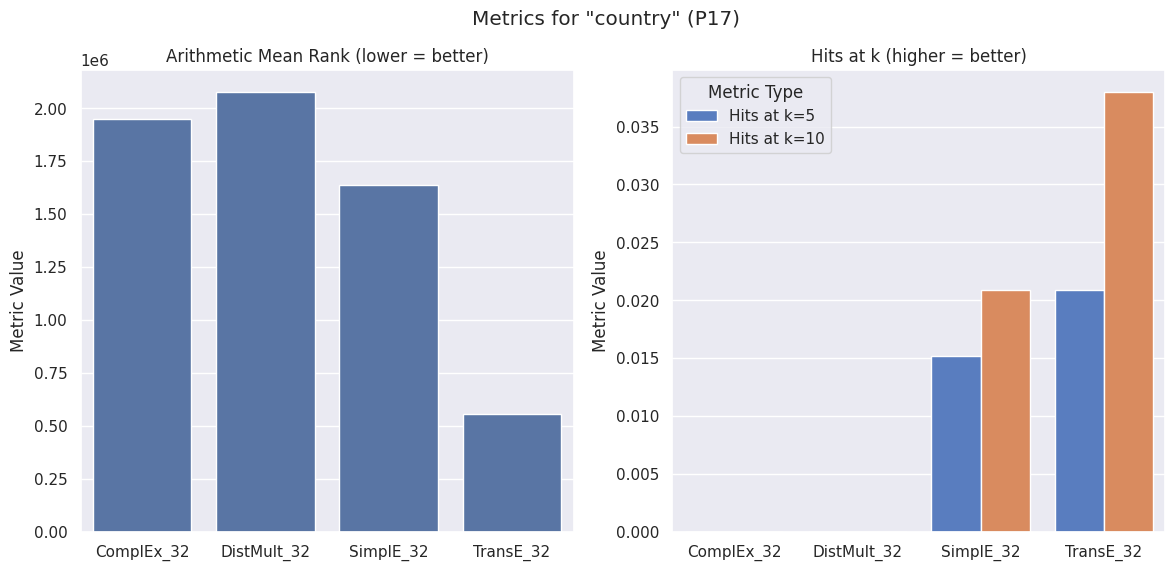

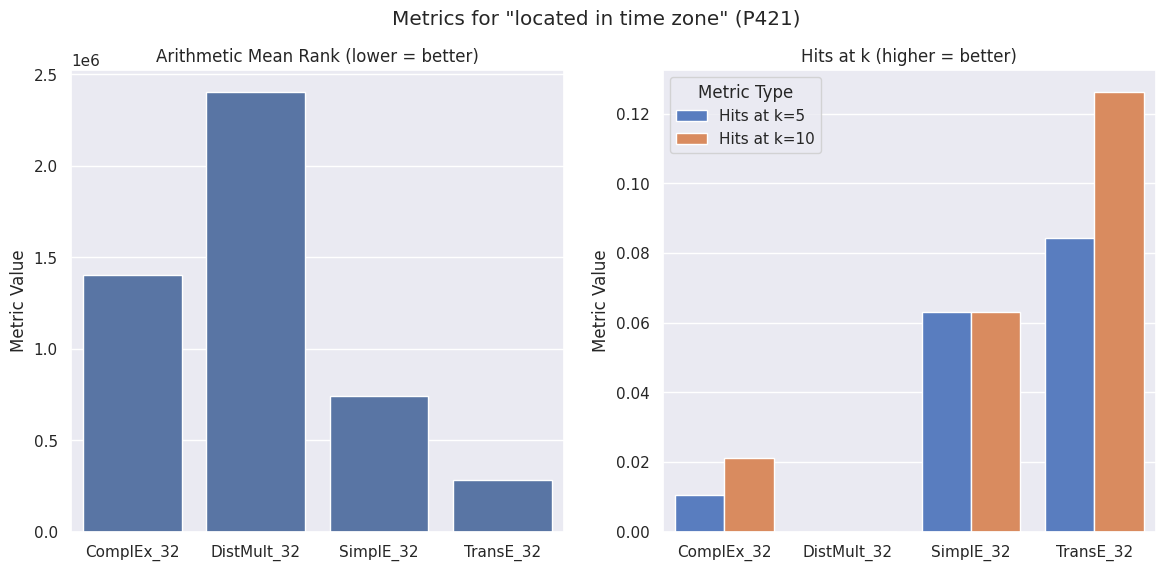

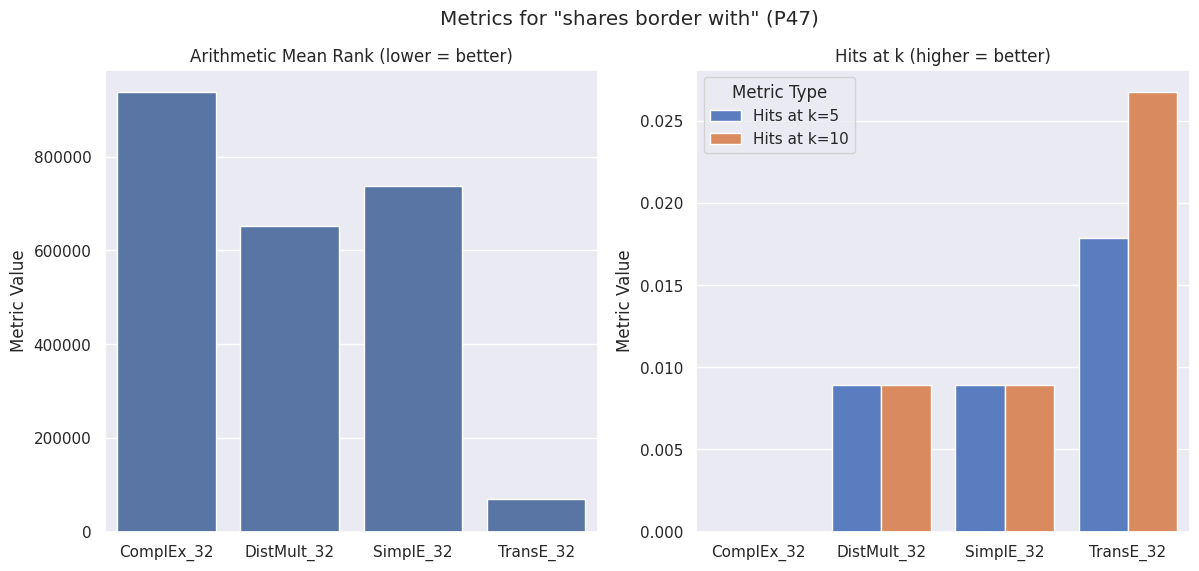

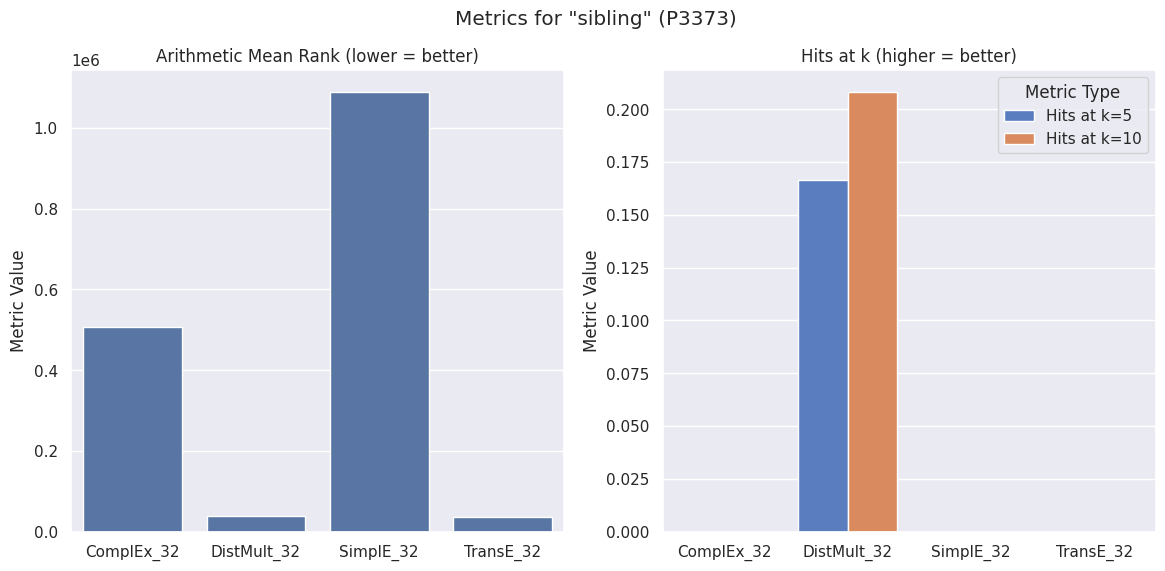

In [25]:
def plot_selected_predicate_metrics_grouped(predicate_metrics, predicate_list, embedding_dim=32, ylim_extend=1):
    sns.set_theme(style=SEABORN_THEME)

    wikidata_labels = get_wikidata_property_labels(predicate_list)

    for pred in predicate_list:
        pred_df = predicate_metrics[predicate_metrics['relation_label'] == pred]
        w_label = wikidata_labels[pred]

        # Sort by metric name to ensure correct ordering
        pred_df = pred_df.sort_values(by=['Metric', 'model'])

        # Filter values for each metric
        amr_values = pred_df[pred_df['Metric'] == 'arithmetic_mean_rank']
        hits5_values = pred_df[pred_df['Metric'] == 'hits_at_5']
        hits10_values = pred_df[pred_df['Metric'] == 'hits_at_10']

        # Invert arithmetic mean rank to have bigger values be better and
        # to comply with the hits at k axis (easier readability of the plot)
        # Hint: Add +1 to num_entities because PyKEEN ranks are 1-based
        inv_amr_values = (WIKIDATA5M_TRANSDUCTIVE_NUM_ENTITIES + 1) - amr_values['Value'].values

        # Create figure and axes
        fig, ax1 = plt.subplots(figsize=(10, 6))
        fig.suptitle(f'Metrics for {pred} (Wikidata: "{w_label}")')
        colors = ['blue', 'red', 'green']
        model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']

        model_labels = [f'{model}_{embedding_dim}' for model in model_labels]

        # Set bar width and positions
        bar_width = 0.2
        x_pos = np.arange(len(amr_values['model']))
        bar1_pos = x_pos - bar_width
        bar2_pos = x_pos
        bar3_pos = x_pos + bar_width

        # Plot Arithmetic Mean Rank on the left y-axis
        ax1.bar(bar1_pos, inv_amr_values, color=colors[0], width=bar_width, label='Arithmetic Mean Rank', zorder=3)
        ax1.set_ylabel('Inverted Arithmetic Mean Rank', color=colors[0])
        ax1.tick_params(axis='y', labelcolor=colors[0], zorder=0)
        ax1.grid(False)
        ax1.set_xticks(bar2_pos)
        ax1.set_xticklabels(model_labels)

        # Create a second y-axis for Hits at 5 and 10
        ax2 = ax1.twinx()
        ax2.bar(bar2_pos, hits5_values['Value'], color=colors[1], width=bar_width, label='Hits at k=5', zorder=3)
        ax2.bar(bar3_pos, hits10_values['Value'], color=colors[2], width=bar_width, label='Hits at k=10', zorder=3)
        ax2.set_ylabel('Hits at k', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(False)

        # Extend the y-axis to the top to create space for the legend,
        # without overlapping the bars
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * ylim_extend)
        ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * ylim_extend)

        # Combine legends for both axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        # Show plot
        plt.show()
        

def plot_selected_predicate_metrics_subplots(predicate_metrics, predicate_list, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)
    
    wikidata_labels = get_wikidata_property_labels(predicate_list)
    
    for pred in predicate_list:
        pred_df = predicate_metrics[predicate_metrics['relation_label'] == pred]
        w_label = wikidata_labels[pred]
        
        # Sort by metric name to ensure correct ordering
        pred_df = pred_df.sort_values(by=['Metric', 'model'])

        # Filter values for different metrics
        amr_values = pred_df[pred_df['Metric'] == 'arithmetic_mean_rank']
        hits_at_k_values = pred_df[pred_df['Metric'].isin(['hits_at_5', 'hits_at_10'])]
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
        fig.suptitle(f'Metrics for "{w_label}" ({pred})')
        model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
            
        model_labels = [f'{model}_{embedding_dim}' for model in model_labels]
        hits_at_k_order = ['hits_at_5', 'hits_at_10']
        
        ax1 = sns.barplot(ax=axes[0], data=amr_values, x='model', y='Value')
        ax1.set_title('Arithmetic Mean Rank (lower = better)')
        ax1.set_xlabel('')
        ax1.set_ylabel('Metric Value')
        ax1.set_xticks(np.arange(len(model_labels)))
        ax1.set_xticklabels(model_labels)
        
        ax2 = sns.barplot(ax=axes[1], data=hits_at_k_values, x='model', y='Value', hue='Metric', hue_order=hits_at_k_order, palette='muted')
        ax2.set_title('Hits at k (higher = better)')
        ax2.set_xlabel('')
        ax2.set_ylabel('Metric Value')
        ax2.set_xticks(np.arange(len(model_labels)))
        ax2.set_xticklabels(model_labels)
        
        if embedding_dim == 512:
            sns.move_legend(ax2, "upper center")
        
        set_plot_legend_texts(ax2, 'Metric Type', ['Hits at k=5', 'Hits at k=10'])
        plt.savefig(f'./plots/predicate_metrics_dim{embedding_dim}_{pred}.pdf', bbox_inches='tight')
        plt.show()


# plot_selected_predicate_metrics_grouped(dim32_predicate_metrics, example_predicates, embedding_dim=32, ylim_extend=1.05)
plot_selected_predicate_metrics_subplots(dim32_predicate_metrics, example_predicates, embedding_dim=32)

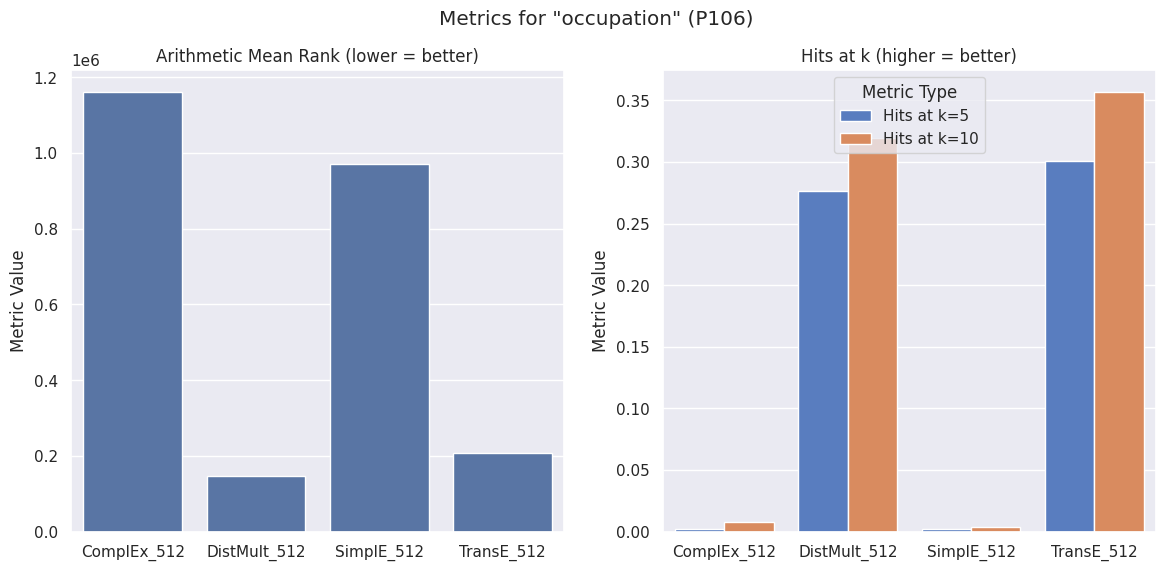

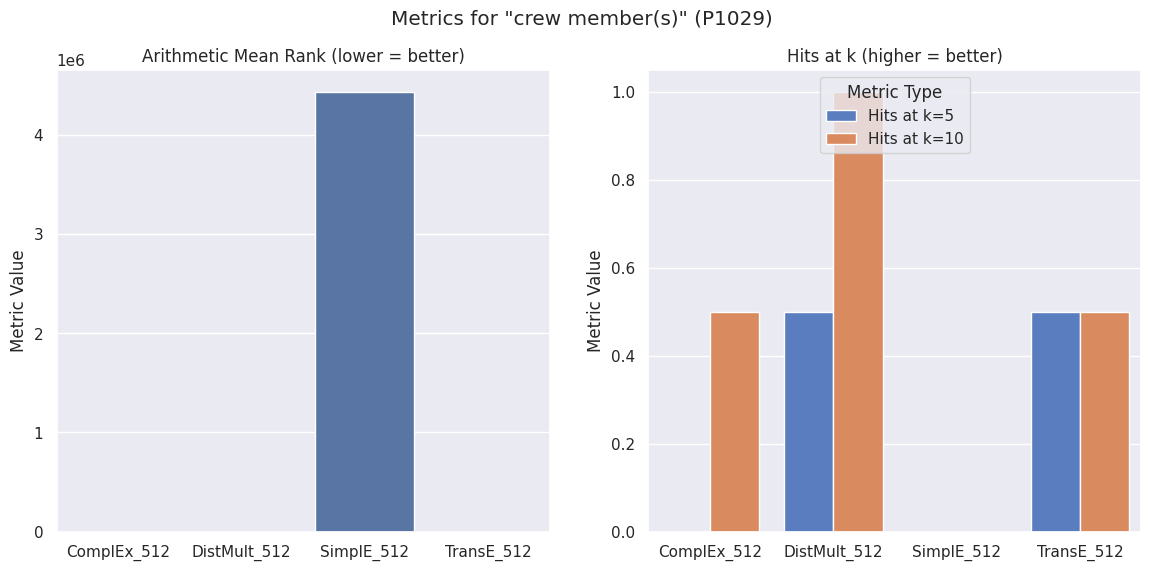

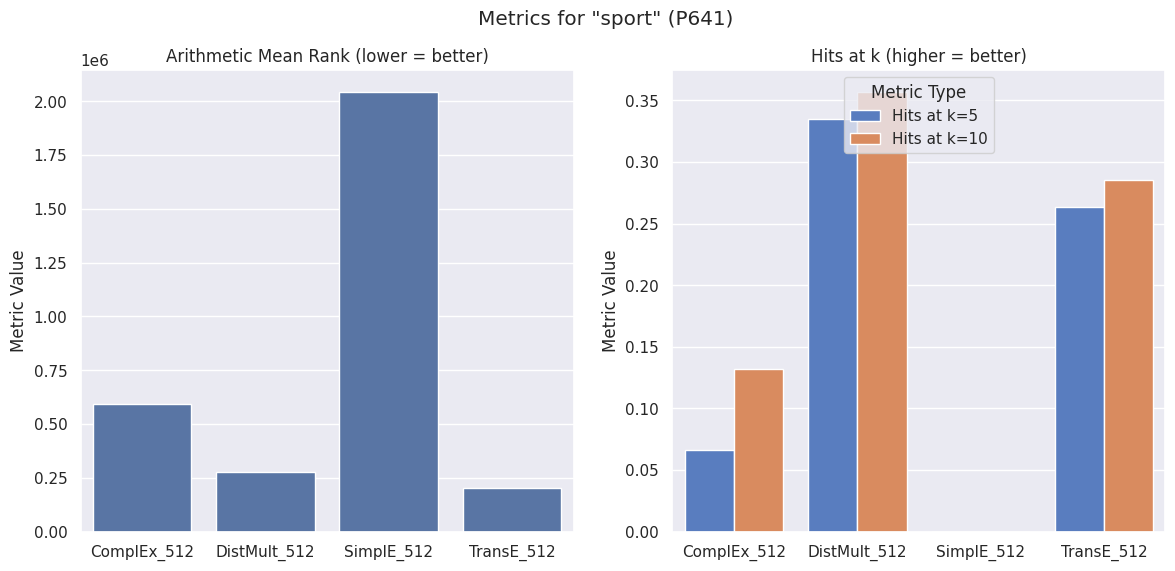

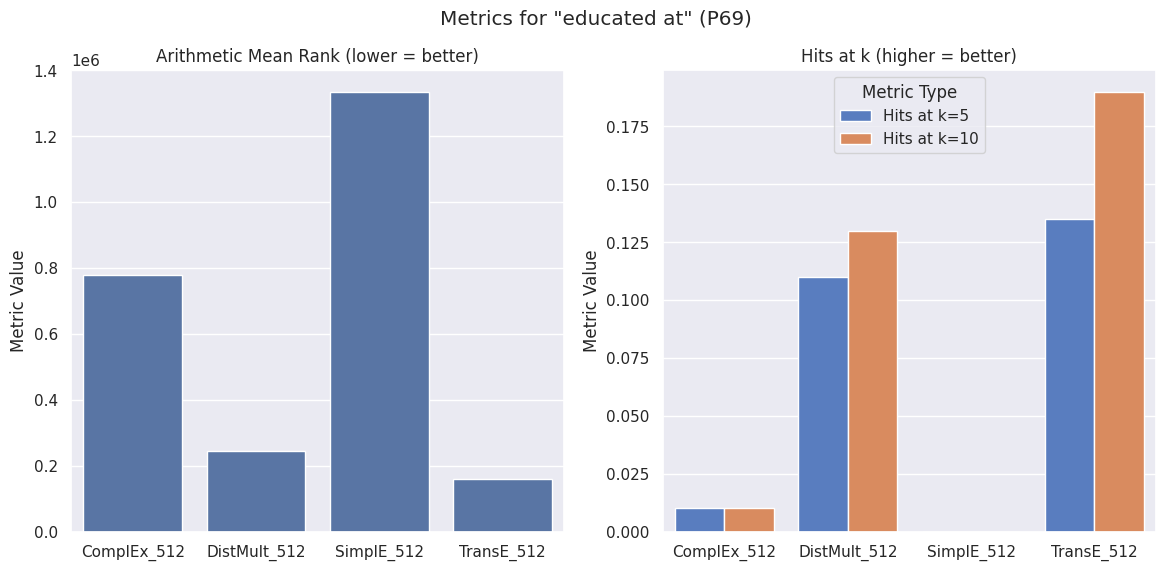

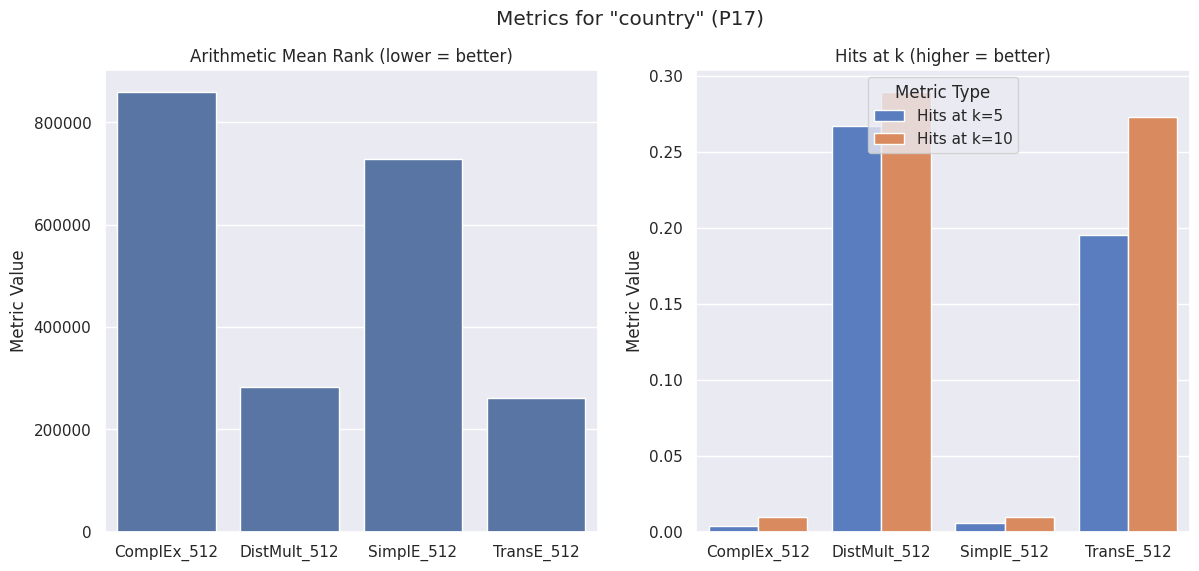

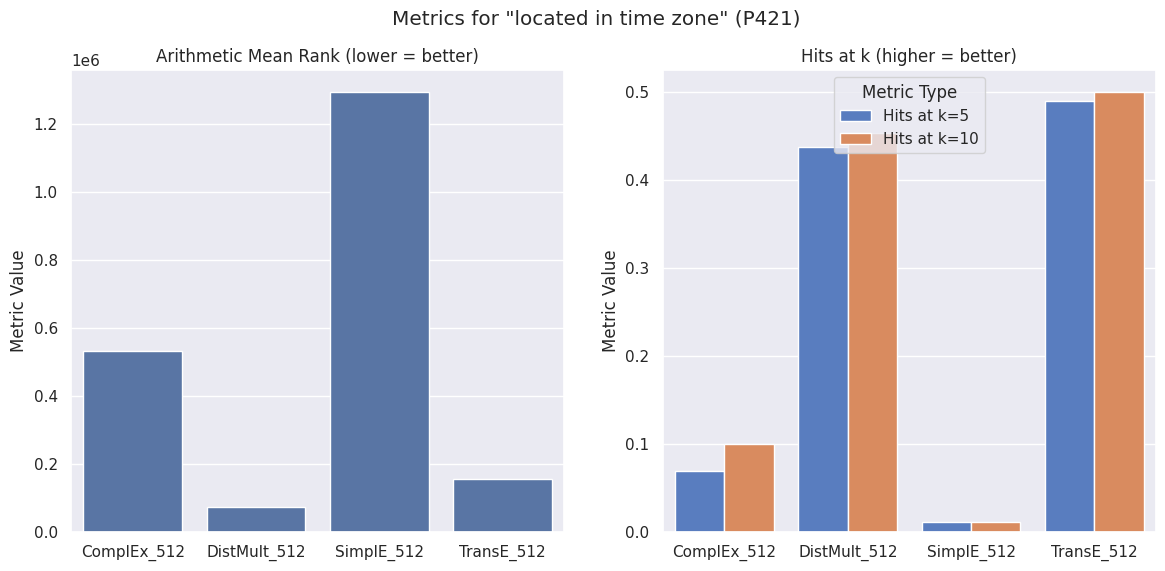

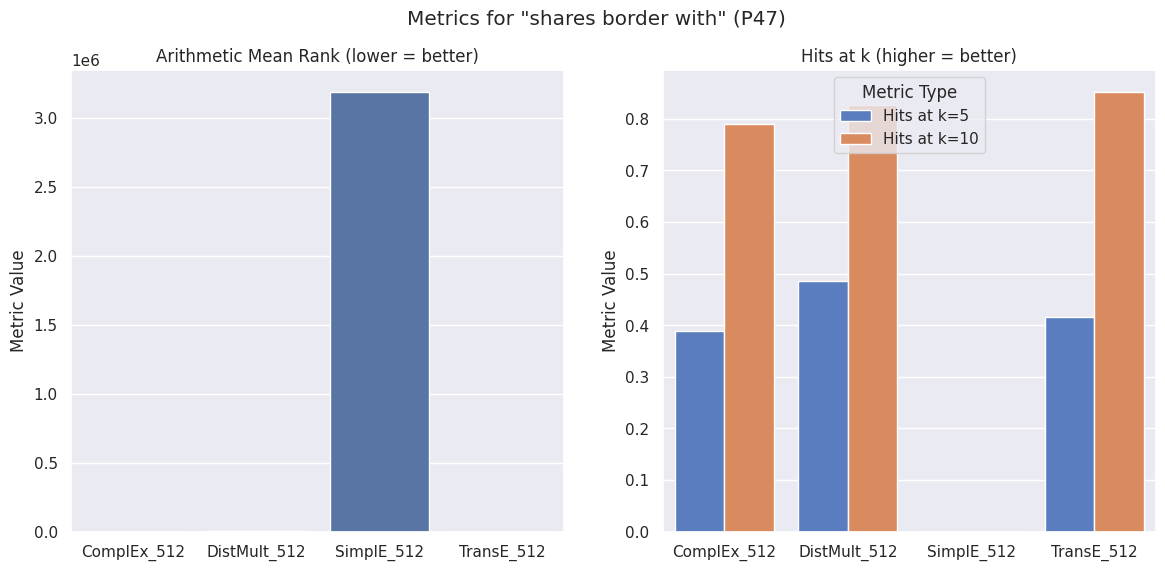

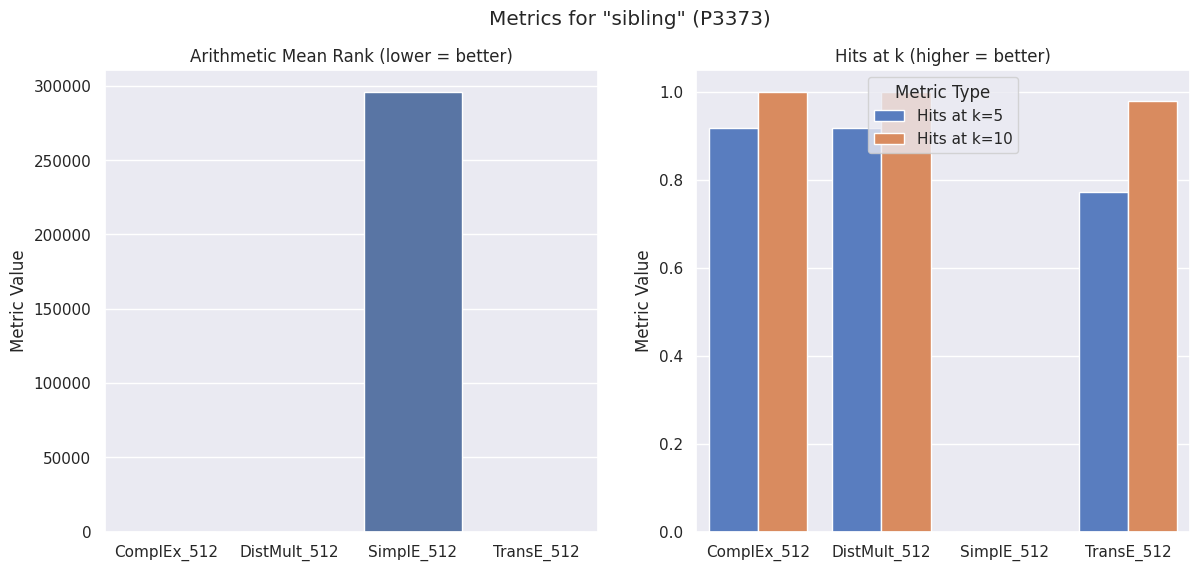

In [26]:
# plot_selected_predicate_metrics_grouped(dim512_predicate_metrics, example_predicates, embedding_dim=512, ylim_extend=1.17)
plot_selected_predicate_metrics_subplots(dim512_predicate_metrics, example_predicates, embedding_dim=512)

In [27]:
dim32_predicate_metrics.query('Metric == "arithmetic_mean_rank" and relation_label == "P3373"')

,Side,Type,Metric,Value,relation_id,relation_label,model
27140,both,realistic,arithmetic_mean_rank,5.079182e+05,491,P3373,complex
74390,both,realistic,arithmetic_mean_rank,3.921674e+04,491,P3373,distmult
121640,both,realistic,arithmetic_mean_rank,1.090168e+06,491,P3373,simple
168890,both,realistic,arithmetic_mean_rank,3.535006e+04,491,P3373,transe


In [28]:
def compute_dataset_predicate_counts(predicates):
    triples_df = wikidata5m_train[wikidata5m_train['P'].isin(predicates)]
    
    wikidata_labels = get_wikidata_property_labels(predicates)

    predicate_counts = []
    individual_object_counts = []
    for pred, p_triples in triples_df.groupby(by='P'):
        pred_count = len(p_triples)
        w_label = wikidata_labels[pred]
        
        total_subject_count = len(p_triples['S'].unique())
        total_object_count = len(p_triples['O'].unique())
        
        predicate_counts.append([pred, w_label, pred_count, total_subject_count, total_object_count])
    
        object_counts_per_subject = p_triples.drop_duplicates(subset=['S', 'P', 'O']).value_counts(subset=['S', 'P'])
        object_counts_per_subject = object_counts_per_subject.rename('object_count').reset_index()
        
        individual_object_counts.append(object_counts_per_subject)

    predicate_counts_df = pd.DataFrame(predicate_counts, columns=['P', 'wd_label', 'pred_count', 'total_subject_count', 'total_object_count'])
    individual_object_counts_df = pd.concat(individual_object_counts)

    return predicate_counts_df, individual_object_counts_df


example_predicate_counts, example_predicate_object_counts = compute_dataset_predicate_counts(example_predicates)
example_predicate_counts

,P,wd_label,pred_count,total_subject_count,total_object_count
0,P1029,crew member(s),1766,433,594
1,P106,occupation,1100875,809940,2791
2,P17,country,1374717,1359255,922
3,P3373,sibling,75615,34083,34517
4,P421,located in time zone,404751,270094,103
5,P47,shares border with,429768,91822,92189
6,P641,sport,485665,481076,453
7,P69,educated at,439703,320070,16764


In [29]:
print(f'Number of object counts: {len(example_predicate_object_counts):,}')
example_predicate_object_counts.groupby('P')['object_count'].mean().sort_values(ascending=False)

Number of object counts: 3,366,773


P
P47      4.680447
P1029    4.078522
P3373    2.218555
P421     1.498556
P69      1.373771
P106     1.359206
P17      1.011375
P641     1.009539
Name: object_count, dtype: float64

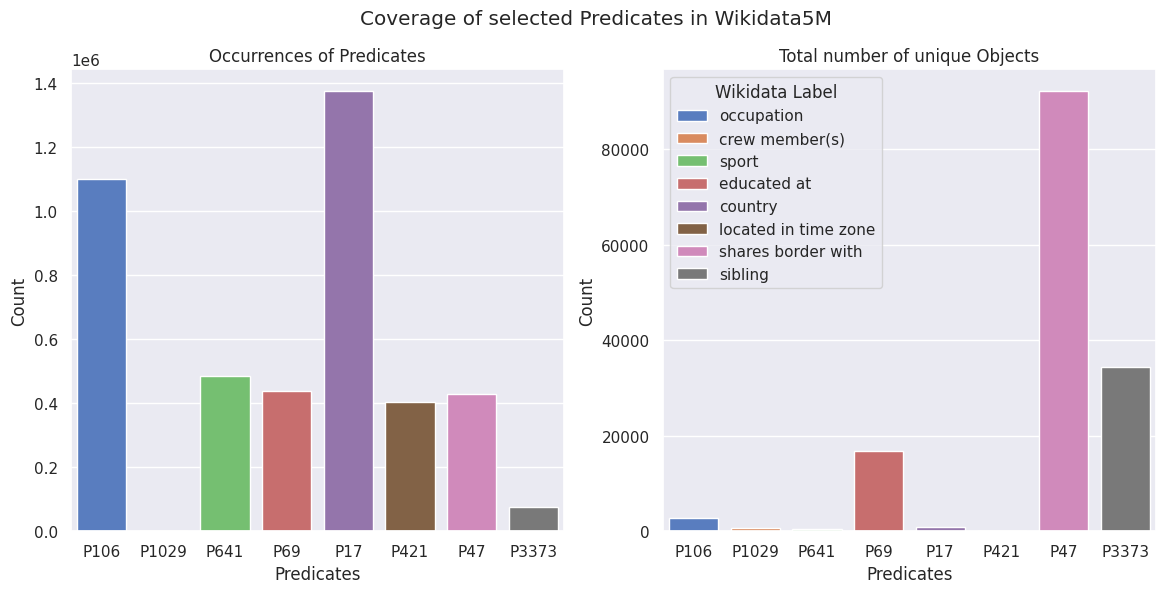

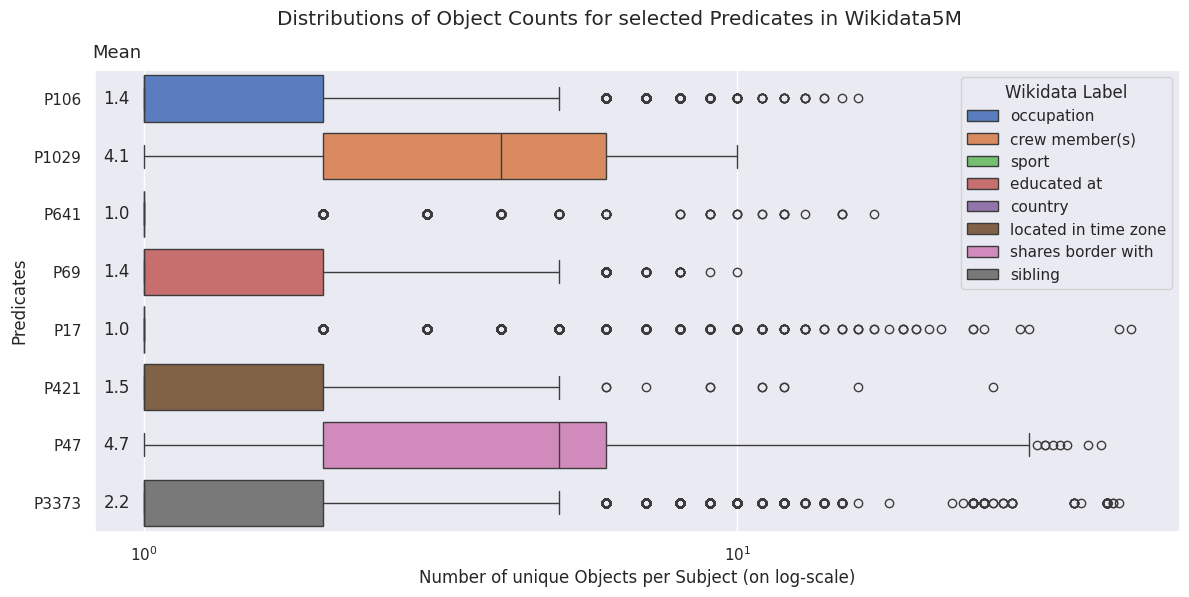

In [30]:
def plot_dataset_predicate_counts(predicate_counts, object_counts, sort_order):
    sns.set_theme(style=SEABORN_THEME)
    
    log_scale = True
    
    boxplot_kwargs = {}
    if log_scale:
        boxplot_kwargs['log_scale'] = 10
    
    wikidata_labels = get_wikidata_property_labels(sort_order)
    hue_sort_order = []
    legend_wd_texts = []
    for pred in sort_order:
        wd_label = wikidata_labels[pred]
        hue_sort_order.append(wd_label)
        legend_wd_texts.append(f'{wd_label} ({pred})')
    
    # Plotting two side-by-side bar plots with different y-axes
    fig1, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    fig1.suptitle('Coverage of selected Predicates in Wikidata5M')
    
    # Plotting predicate counts
    ax1 = sns.barplot(x='P', y='pred_count', data=predicate_counts, ax=axes[0], hue='wd_label', order=sort_order, hue_order=hue_sort_order, palette='muted', legend=False)
    ax1.set_title('Occurrences of Predicates')
    ax1.set_xlabel('Predicates')
    ax1.set_ylabel('Count')
    
    # Plotting object counts
    ax2 = sns.barplot(x='P', y='total_object_count', data=predicate_counts, ax=axes[1], hue='wd_label', order=sort_order, hue_order=hue_sort_order, palette='muted')
    ax2.set_title('Total number of unique Objects')
    ax2.set_xlabel('Predicates')
    ax2.set_ylabel('Count')
    ax2.legend(title='Wikidata Label')
    #set_plot_legend_texts(ax2, 'Wikidata Label', legend_wd_texts)
    
    plt.savefig(f'../kge-thesis/images/experiments/predicate_counts.pdf', bbox_inches='tight')
    plt.show()
    
    for (_, pred, wd_label) in predicate_counts[['P', 'wd_label']].itertuples():
        object_counts.loc[object_counts['P'] == pred, 'wd_label'] = wd_label
        
    object_count_means = object_counts.groupby('P')['object_count'].mean()
    
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle('Distributions of Object Counts for selected Predicates in Wikidata5M')
    
    ax3 = sns.boxplot(y='P', x='object_count', data=object_counts, order=sort_order, orient='y', hue='wd_label', hue_order=hue_sort_order, palette='muted', **boxplot_kwargs)
    ax3.set_xlabel('Number of unique Objects per Subject (on log-scale)')
    ax3.set_ylabel('Predicates')
    ax3.legend(title='Wikidata Label')
    #set_plot_legend_texts(ax3, 'Wikidata Label', legend_wd_texts)
    
    mean_text_x_pos = -4
    ax_text_kwargs = {}
    
    if log_scale:
        mean_text_x_pos = 0.02
        
        # Transform to place text properly on log-scaled x-axis
        log_scale_transform = transforms.blended_transform_factory(
            ax3.transAxes,   # Use axes coordinates for log-scaled x-axis
            ax3.transData    # Use data coordinates for y-axis
        )
        
        ax_text_kwargs = {'transform': log_scale_transform}
    
    predicate_yticks = ax3.get_yticks()
    predicate_ylabels = ax3.get_yticklabels()
    ax3.text(mean_text_x_pos, -0.8, 'Mean', ha='center', va='center', size=13, **ax_text_kwargs)
    for ytick, ylabel in zip(predicate_yticks, predicate_ylabels):
        mean_value = object_count_means[ylabel.get_text()]
        ax3.text(mean_text_x_pos, ytick, '%.1f' % mean_value, ha='center', va='center', size='medium', **ax_text_kwargs)
    
    plt.savefig(f'./plots/predicate_object_counts.pdf', bbox_inches='tight')
    plt.show()
    

plot_dataset_predicate_counts(example_predicate_counts, example_predicate_object_counts, ['P106', 'P1029', 'P641', 'P69', 'P17', 'P421', 'P47', 'P3373'])

## Properties of selected predicates

### `P31` (instance of)

- that class of which this subject is a particular example and member
- relationship between instances with a common characteristic and a class characterized by this characteristic
- Use "instance of" instead of "subclass of" when there is no class hierarchy relationship
    - Example: "Atlantic Ocean" and "Pacific Ocean" are instances of "Ocean", but not subclasses
- not transitive
    - Example: "Angela Merkel" instance of "politician", "politician" instance of "profession", but "Angela Merkel" is not a "profession"
- not reflexive
- asymmetric

### `P106` (occupation)

- occupation of a person
- not transitive/reflexive/symmetric

### `P413` (position played on team / speciality)

- position or specialism of a player on a team
- not transitive/reflexive/symmetric

### `P421` (located in time zone)

- time zone for this item
- not transitive/reflexive/symmetric

### `P641` (sport)

- sport that the subject participates or participated in or is associated with
- not transitive/reflexive/symmetric

### `P47` (shares border with)

- countries or administrative subdivisions, of equal level, that this item borders, either by land or water. A single common point is enough.
- symmetric property
    - Example: "South Africa" shares border with "Botswana", "Botswana" shares border with "South Africa"
- not transitive/reflexive

### `P1344` (participant in)

- event in which a person or organization was/is a participant
- not transitive/reflexive/symmetric

### `P364` (original language of film or TV show)

- language in which a film or a performance work was originally created
- Deprecated for written works and songs; use P407 ("language of work or name") instead.
- not transitive/reflexive/symmetric